In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as units
#from dustmaps.bayestar import BayestarWebQuery
import numpy as np
import os
from bokeh.plotting import *
output_notebook()
%load_ext autoreload
%autoreload 2
from getGaiaData import GaiaClusterMembers
from astropy.modeling.models import KingProjectedAnalytic1D
from astropy.modeling import models, fitting
import scipy.optimize
import scipy.stats as stats
import hdbscan
#from dustmaps.config import config
#config.reset()

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#NGC_2423, NGC_6819 and NGC_7789 have a min membership of 0.5
## BEST PRACTICES FOR SINGLEPOP
To avoid logPost = -inf,make sure the phot file is properly formated, it is very particular. 
CMprior should be between 0.01 and 0.9 for singlePop.  A continuous logPost = -inf means there is a problem with either the phot file or the yaml file (make sure ther are no nans for the prior, sigma, or starting values).  It is possible for a sampling to start in logPost = -inf and move out of it.

In [3]:
clusters = ['Berkeley_32', 'Berkeley_39', 'Collinder_394', 'Haffner_22',
       'Melotte_71', 'NGC_188', 'NGC_1245', 'NGC_1664', 'NGC_1817',
       'NGC_1912', 'NGC_2099', 'NGC_2168', 'NGC_2281', 'NGC_2287',
       'NGC_2301', 'NGC_2323', 'NGC_2324', 'NGC_2355', 'NGC_2360',
       'NGC_2420', 'NGC_2423', 'NGC_2437', 'NGC_2447', 'NGC_2506',
       'NGC_2539', 'NGC_2548', 'NGC_2627', 'NGC_2682', 'NGC_6716',
       'NGC_6819', 'NGC_6940', 'NGC_7209', 'NGC_7243', 'NGC_7789',
       'Ruprecht_171', 'Tombaugh_1', 'Trumpler_3']
#HDBSCAN_params = pd.DataFrame(columns=['Cluster','Radius','Min_size', 'Group'])

In [4]:
HDBSCAN_params = pd.read_csv('HDBSCAN_params.csv',sep=' ')

In [5]:
HDBSCAN_params

,Cluster,Radius,Min_size,Group,no_points
0,Berkeley_32,0.50,50,0,559
1,Berkeley_39,0.10,10,1,635
2,Collinder_394,1.50,150,1,612
3,Haffner_22,0.10,2,161,239
4,Melotte_71,0.25,50,1,1128
5,NGC_188,0.25,10,2,1098
6,NGC_1245,0.10,5,7,486
7,NGC_1664,0.10,10,0,242
8,NGC_1817,0.25,5,28,561
9,NGC_1912,0.25,20,1,684


Pulling from Hunt
Prior distance =  3464.112598452526  pc
Cluster distance =  3232.8368785953535  pc


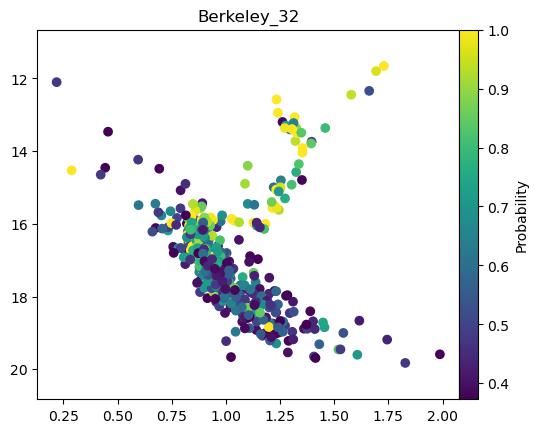

done.
Pulling from Hunt
Prior distance =  4246.293412856602  pc
Cluster distance =  3469.5264590034276  pc


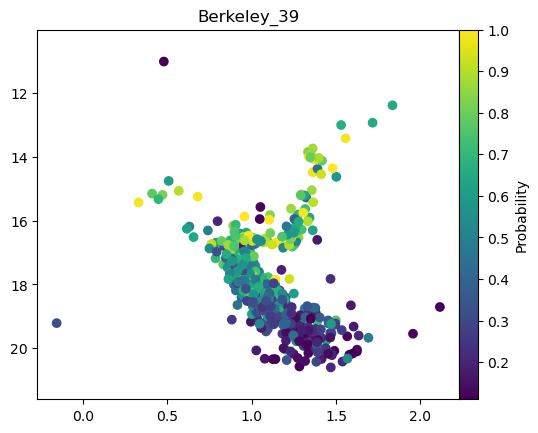

done.
Pulling from Hunt
Prior distance =  718.6244677608113  pc
Cluster distance =  726.8402322286456  pc


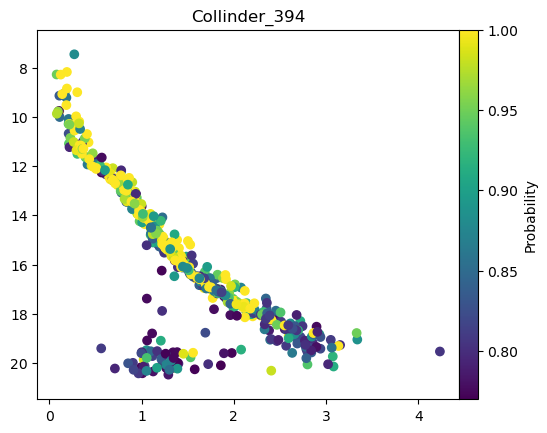

done.
Pulling from Hunt
Prior distance =  2727.9977010872212  pc
Cluster distance =  2823.3611074622663  pc


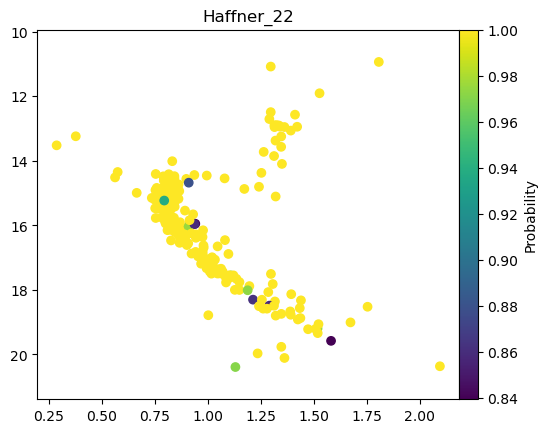

done.
Pulling from Hunt
Prior distance =  2257.324524715215  pc
Cluster distance =  2236.961409412247  pc


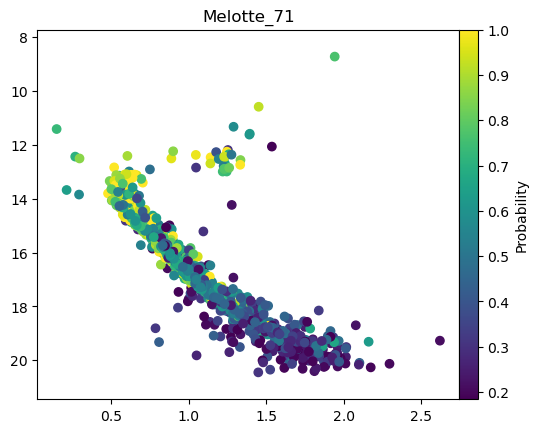

done.
Generating yaml values from literature priors.
Prior distance =  1918.0503346252315  pc
Cluster distance =  1894.655862792475  pc


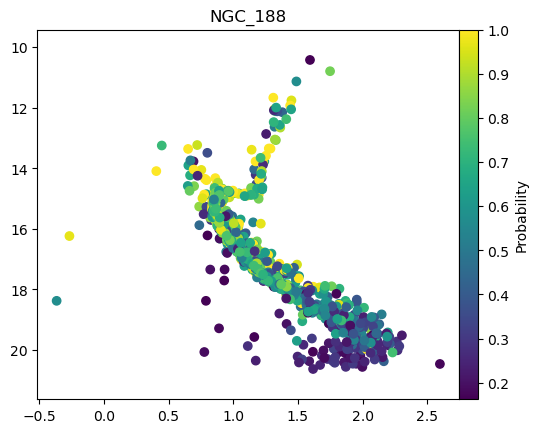

done.
Generating yaml values from literature priors.
Prior distance =  2866.6191646487287  pc
Cluster distance =  3109.2854456052455  pc


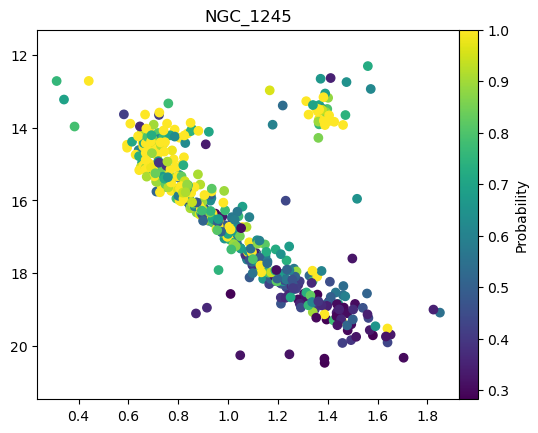

done.
Generating yaml values from literature priors.
Prior distance =  1215.312598425186  pc
Cluster distance =  1344.600659318685  pc


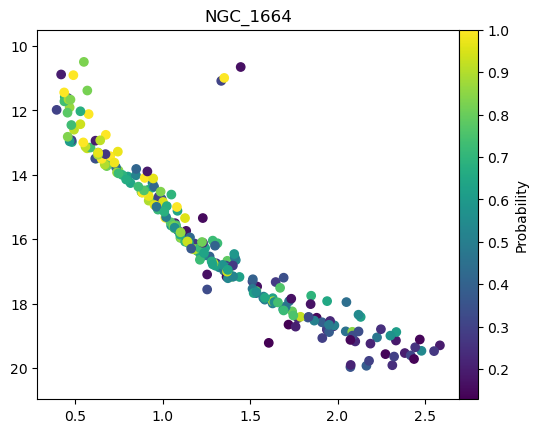

done.
Generating yaml values from literature priors.
Prior distance =  1770.9977115367071  pc
Cluster distance =  1765.8246471494965  pc


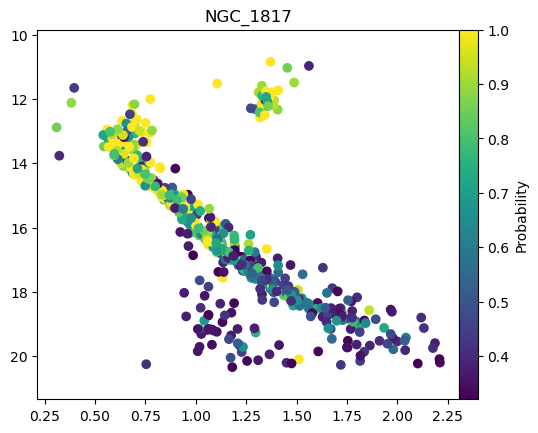

done.
Pulling from Hunt
Prior distance =  1151.5903050364834  pc
Cluster distance =  1140.3580733208596  pc


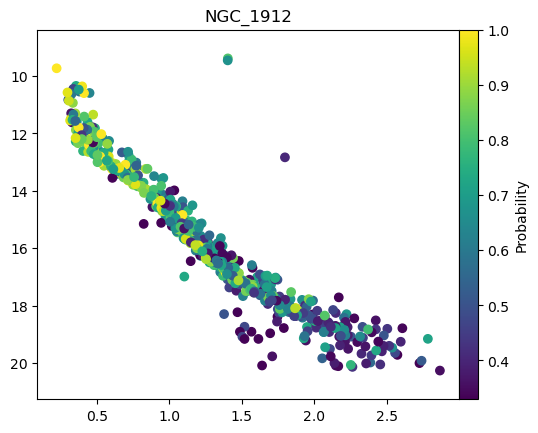

done.
Pulling from Hunt
Prior distance =  1485.4225069185852  pc
Cluster distance =  1475.5477978508038  pc


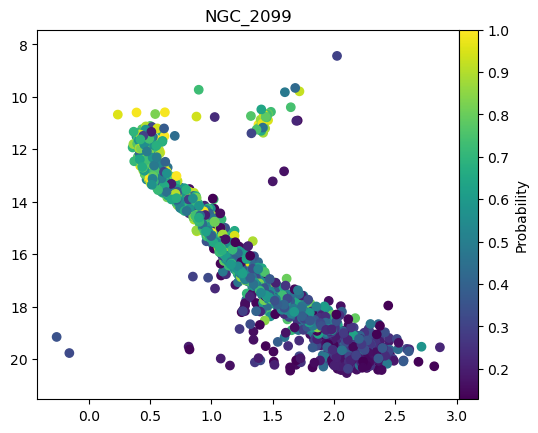

done.
Pulling from Hunt
Prior distance =  891.5506069460107  pc
Cluster distance =  868.7752163486905  pc


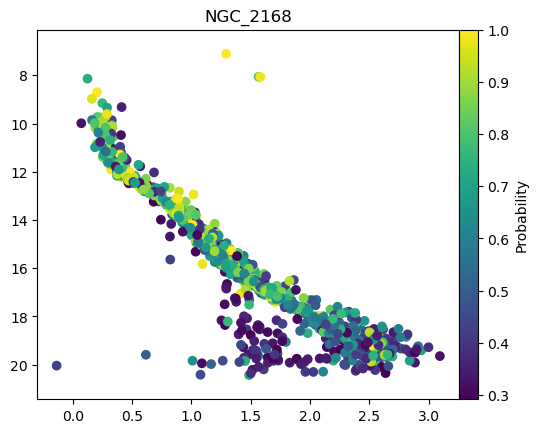

done.
Generating yaml values from literature priors.
Prior distance =  527.6282010776783  pc
Cluster distance =  521.8330723986908  pc


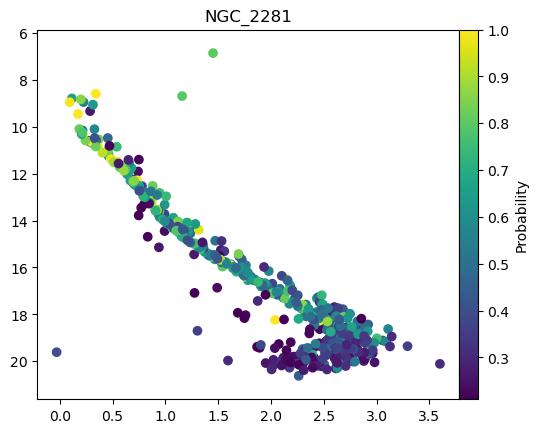

done.
Pulling from Hunt
Prior distance =  749.0486057937259  pc
Cluster distance =  737.4295545440634  pc


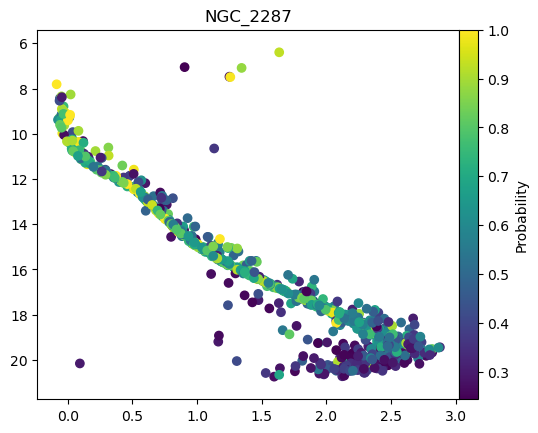

done.
Generating yaml values from literature priors.
Prior distance =  831.6412068947022  pc
Cluster distance =  875.1040291667373  pc


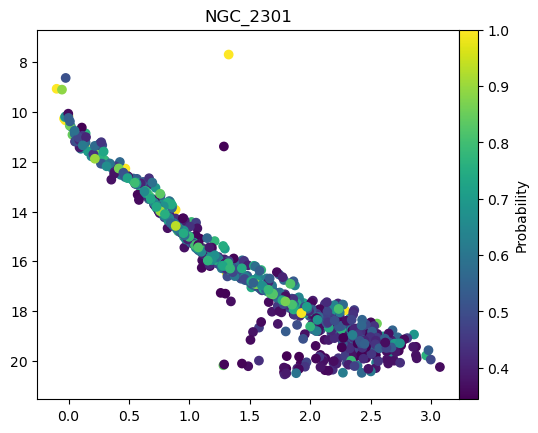

done.
Pulling from Hunt
Prior distance =  998.4630554687119  pc
Cluster distance =  1001.5510660466321  pc


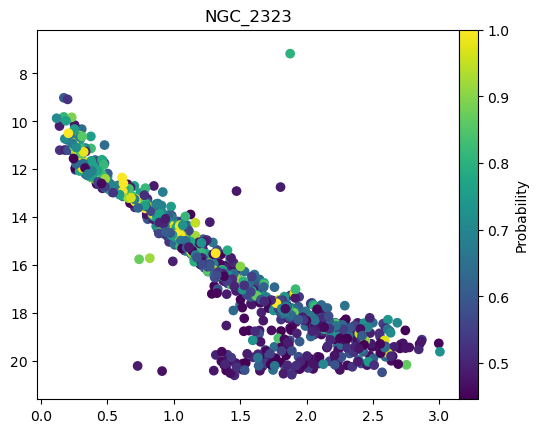

done.
Generating yaml values from literature priors.
Prior distance =  3789.291363310516  pc
Cluster distance =  3810.6427728467993  pc


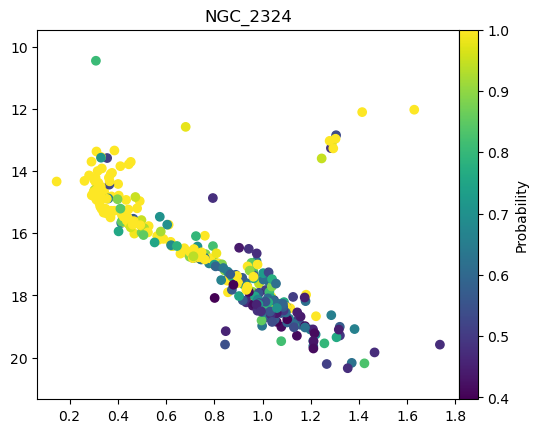

done.
Generating yaml values from literature priors.
Prior distance =  2111.5433406588395  pc
Cluster distance =  1879.0686535537566  pc


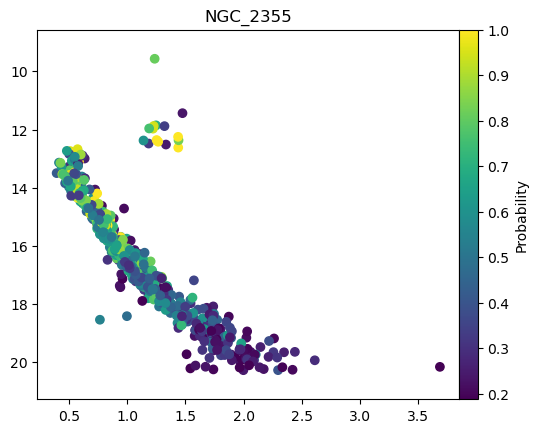

done.
Generating yaml values from literature priors.
Prior distance =  1640.7711079029455  pc
Cluster distance =  1092.0826133690052  pc


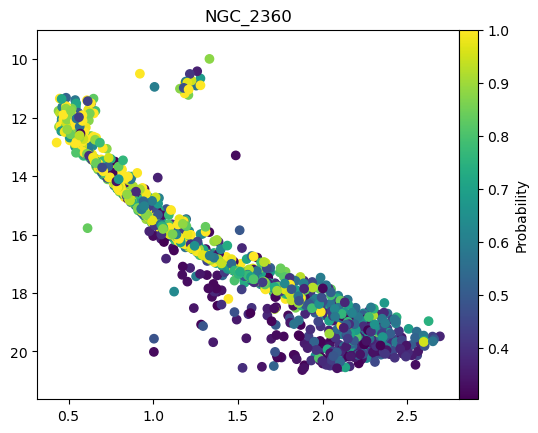

done.
Generating yaml values from literature priors.
Prior distance =  2896.583150173506  pc
Cluster distance =  2503.2940481521664  pc


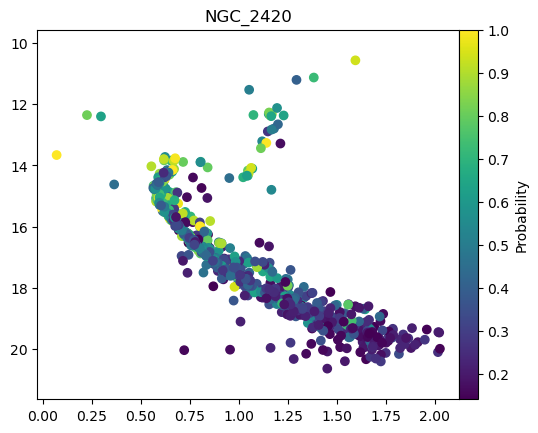

done.
Generating yaml values from literature priors.
Prior distance =  820.956224430679  pc
Cluster distance =  944.9498101755008  pc


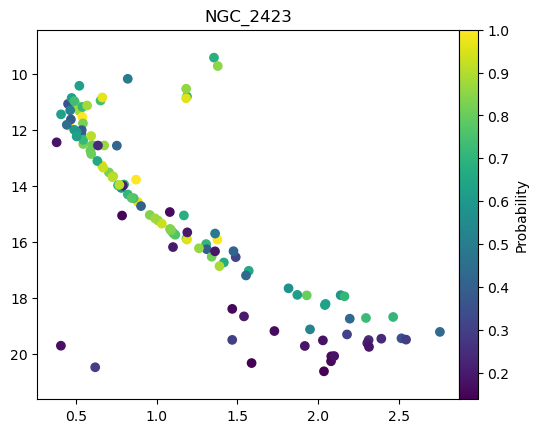

done.
Generating yaml values from literature priors.
Prior distance =  1409.6133365221667  pc
Cluster distance =  1669.2582424634036  pc


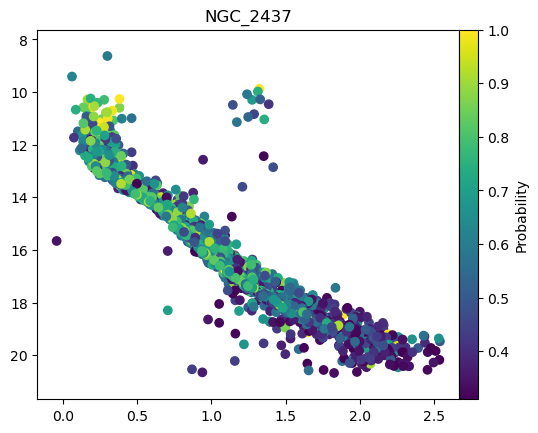

done.
Generating yaml values from literature priors.
Prior distance =  1041.1133131083104  pc
Cluster distance =  1010.4683372399086  pc


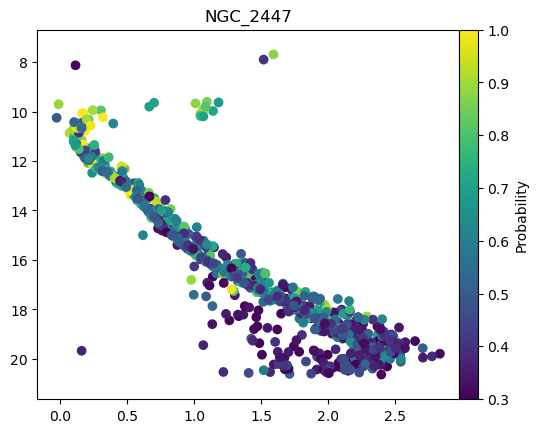

done.
Generating yaml values from literature priors.
Prior distance =  3328.0665337807623  pc
Cluster distance =  3167.1984468628893  pc


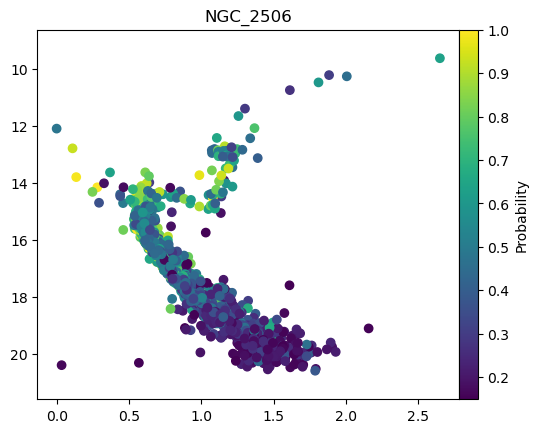

done.
Generating yaml values from literature priors.
Prior distance =  1301.4874960156328  pc
Cluster distance =  1323.6829590214868  pc


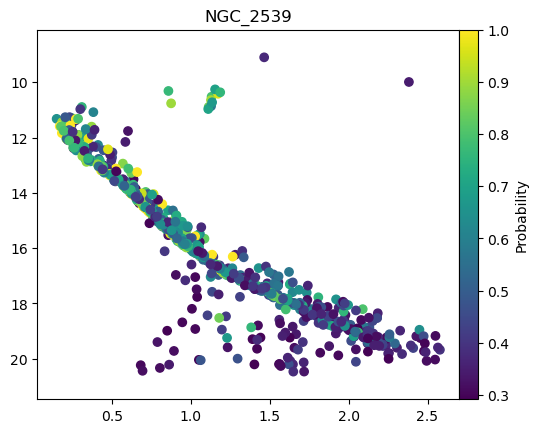

done.
Pulling from Hunt
Prior distance =  786.6834251584495  pc
Cluster distance =  772.6467858499718  pc


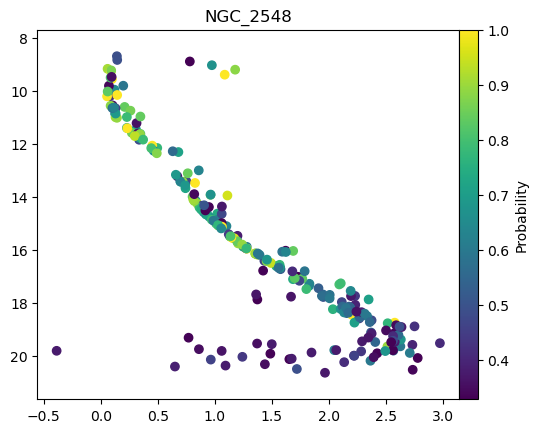

done.
Generating yaml values from literature priors.
Prior distance =  2223.780921680178  pc
Cluster distance =  1858.385749017204  pc


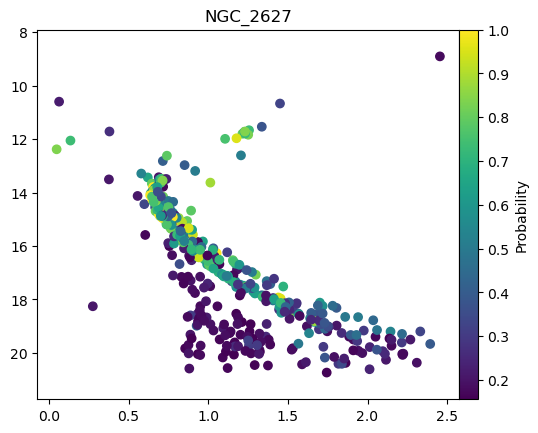

done.
Generating yaml values from literature priors.
Prior distance =  869.0124530821491  pc
Cluster distance =  865.2361273124457  pc


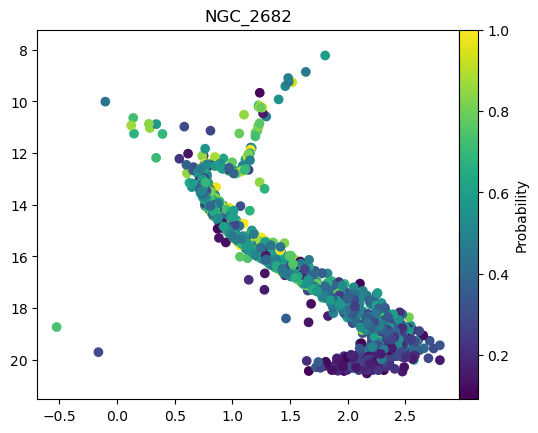

done.
Generating yaml values from literature priors.
Prior distance =  714.6147894734742  pc
Cluster distance =  727.2690138770447  pc


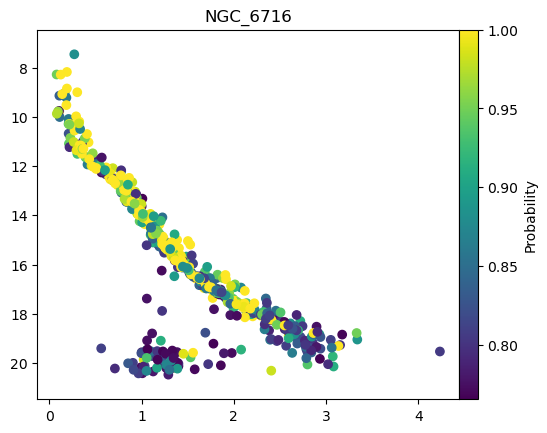

done.
Generating yaml values from literature priors.
Prior distance =  2373.2527894365912  pc
Cluster distance =  2620.9296543632263  pc


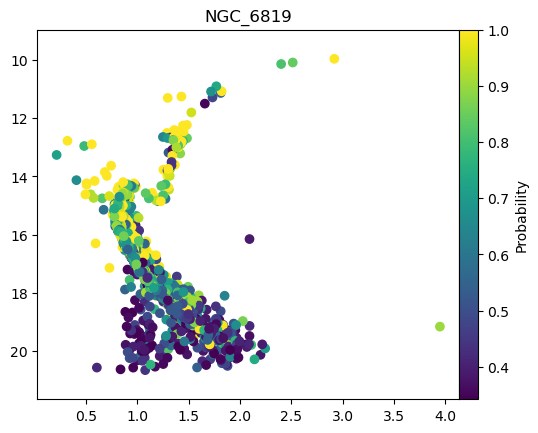

done.
Generating yaml values from literature priors.
Prior distance =  831.7982455405728  pc
Cluster distance =  1045.954032060891  pc


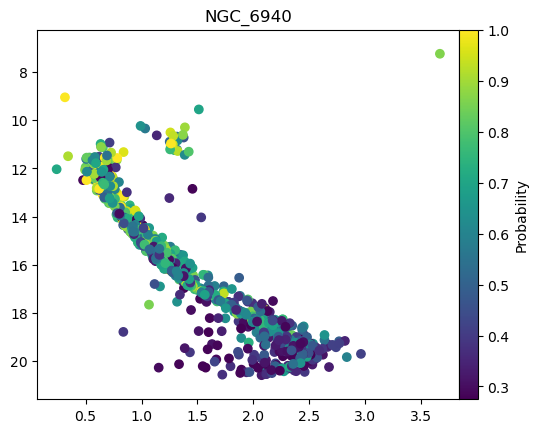

done.
Generating yaml values from literature priors.
Prior distance =  1196.7846216699338  pc
Cluster distance =  1228.4915053476584  pc


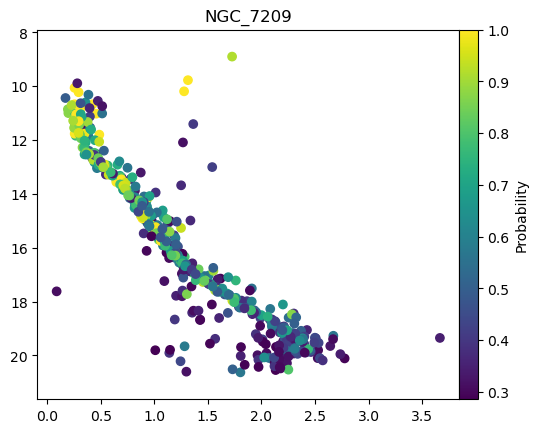

done.
Generating yaml values from literature priors.
Prior distance =  832.8830042622332  pc
Cluster distance =  886.6723898825722  pc


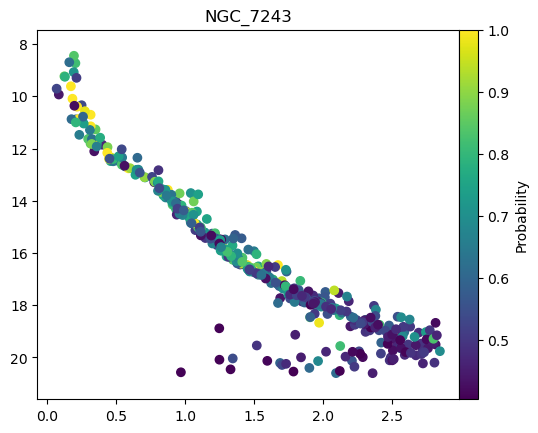

done.
Generating yaml values from literature priors.
Prior distance =  2114.2872946378293  pc
Cluster distance =  2075.534598869271  pc


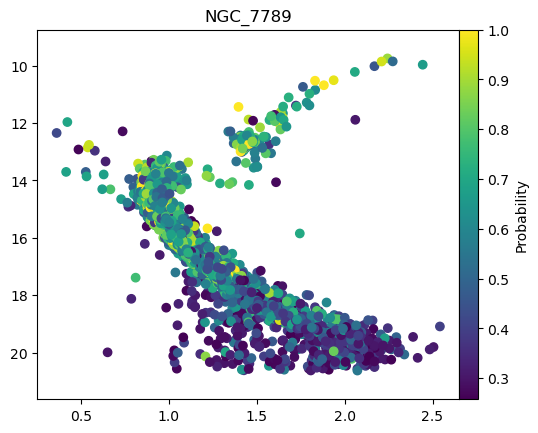

done.
Pulling from Hunt
Prior distance =  1606.4751056460304  pc
Cluster distance =  1562.9908058379524  pc


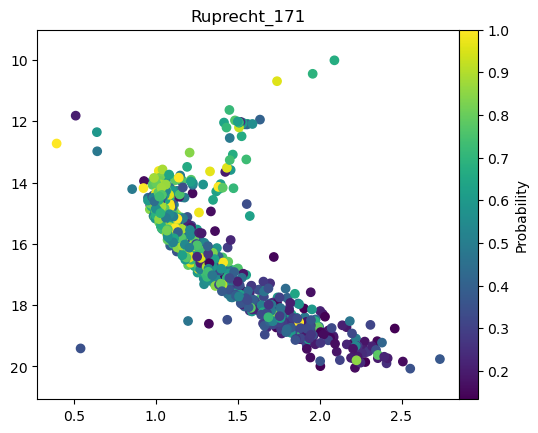

done.
Pulling from Hunt
Prior distance =  2483.5905574489516  pc
Cluster distance =  2505.8208919015406  pc


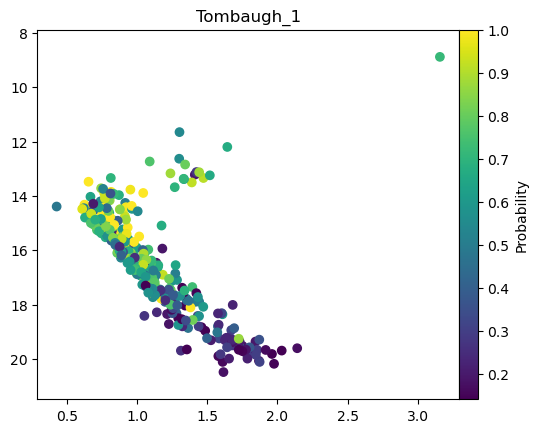

done.
Pulling from Hunt
Prior distance =  690.6022675580261  pc
Cluster distance =  678.6129146685266  pc


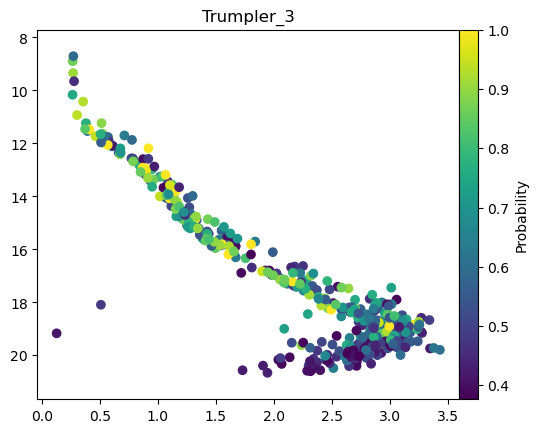

done.


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [11]:
OCdf = pd.read_csv('OCcompiled_clean_v2.csv') #file with prior values for cluster centers from previous literature
Hunt = pd.read_csv('Hunt2023.tsv',sep='\s+', header=94)

def distance_modulus_to_pc(distance_modulus):
    return 10 ** ((distance_modulus + 5) / 5)

def run_pipeline(clusterName):
    #print (clusterName)
    #clusterName = 'NGC_2324'
    cluster = GaiaClusterMembers()
    #cluster.mem_min = .1
    pwd = 'OC_data/'+clusterName+'_dir'
    try:
        os.makedirs(pwd)
        os.makedirs(pwd+'/plots')
    except:
        next
    cluster.plotNameRoot = pwd+'/plots/'
    cluster.photOutputFileName = pwd +'/'+clusterName + '.phot'
    cluster.saveDataFile = pwd +'/'+clusterName + '.csv'
    cluster.yamlOutputFileName = pwd + '/base9.yaml'
    cluster.yamlTemplateFileName = 'template_base9.yaml'
    try:
        params = HDBSCAN_params[HDBSCAN_params['Cluster']==clusterName]
        cluster.lim_radius = params.Radius.values[0]
        cluster.min_cluster_size = params.Min_size.values[0]
        cluster.group_no = params.Group.values[0]
    except:
        print ('No previous HDBSCAN parameters stored for this OC.')
    # try:
    #     print ('Using exisiting res file values to make yaml file')
    #     res_file = "../res_files/"+cluster+"_combined.res"
    #     df=pd.read_csv(res_file,sep='\s+')
    #     params = ['logAge', 'FeH', 'modulus', 'absorption']
    #     row = OCdf.loc[OCdf['ID'] == clusterName].iloc[0]
    #     Mg = 1.5*10**12 #*units.solMass #this probably could use verification and a reference
    #     cluster.rt = row['rgc[pc]']*(row['mass[Msun]']/(3.*Mg))**(1./3.)
    #     dmod = np.median(df['modulus']).values[0]
    #     err_dmod = np.std(df['modulus']).values[0]
    #     FeH = np.median(df['FeH']).values[0]
    #     age = np.median(df['logAge']).values[0]
    #     Av = np.median(df['absorption']).values[0]
    #     cluster.yamlInputDict = {
    #     'photFile' : clusterName + '_sig1.phot',
    #     'outputFileBase' : '/projects/p31721/achilds/new_OC_data/'+clusterName+'_dir',
    #     'modelDirectory' : '/projects/p31721/BASE9/base-models/',
    #     'msRgbModel' : 5,
    #     'Fe_H' : [FeH, FeH, 0.3],
    #     'Av' : [Av, Av, 0.3],
    #     'Y' : [0.29, 0.29, 0.0], # keep the defaults
    #     'carbonicity' : [0.38, 0.38, 0.0], # keep the defaults
    #     'logAge' : [age, age, np.inf],
    #     'distMod' : [dmod, dmod, err_dmod],
    #         }
    
    # except:
    try:
        row = OCdf.loc[OCdf['ID'] == clusterName].iloc[0]
        Mg = 1.5*10**12 #*units.solMass #this probably could use verification and a reference
        cluster.rt = row['rgc[pc]']*(row['mass[Msun]']/(3.*Mg))**(1./3.)
        dmod = round(5.*np.log10(row['dist[pc]']) - 5.,5)
        err_dmod = round((5.*1./np.log(10.)*(1./row['dist[pc]']))*row['err_dist[pc]'],5)# error propagation
        if np.isnan(row['[Fe/H]']):
            row['[Fe/H]'] = 0.0
        if np.isnan(row['err_[Fe/H]']):
            row['err_[Fe/H]'] = 0.3
        try:
            res_file = "res_files/"+clusterName+"_combined.res"
            df=pd.read_csv(res_file,sep='\s+')
            start_dmod = round(np.median(df['modulus']),5)
            start_FeH = round(np.median(df['FeH']),5)
            start_age = round(np.median(df['logAge']),5)
            start_Av = round(np.median(df['absorption']),5)
        except:
            start_dmod = dmod
            start_FeH = round(row['[Fe/H]'],5)
            start_Av = round(row['Av[mag]'],5)
            start_age = round(np.log10(row['age[Myr]']*10**6),5)
        print ('Generating yaml values from literature priors.')
        cluster.yamlInputDict = {
        'photFile' : clusterName + '_sig1.phot',
        'outputFileBase' : clusterName,
        'modelDirectory' : '/projects/p31721/BASE9/base-models/',
        'msRgbModel' : 5,
        'Fe_H' : [start_FeH, row['[Fe/H]'], np.max([row['err_[Fe/H]'], 0.3])],
        'Av' : [start_Av, row['Av[mag]'], np.max([row['err_Av[mag]'], 0.3])],
        'Y' : [0.29, 0.29, 0.0], # keep the defaults
        'carbonicity' : [0.38, 0.38, 0.0], # keep the defaults
        'logAge' : [start_age, np.log10(row['age[Myr]']*10**6),np.inf],
        'distMod' : [start_dmod, dmod, err_dmod],
        }
    except:
        print ('Pulling from Hunt')
        Hunt_data = Hunt[Hunt['Name']==clusterName]
        cluster.rt = Hunt_data['rt'].values[0]
        Av = round(Hunt_data['AV50'].values[0],5)
        err_Av = round(Hunt_data['AV84'].values[0],5)
        logAge = round(Hunt_data['logAge50'].values[0],5)
        dmod = round(Hunt_data['MOD50'].values[0],5)
        err_dmod = round(Hunt_data['MOD50'].values[0]-Hunt_data['MOD16'].values[0],5)
        try:
            res_file = "res_files/"+clusterName+"_combined.res"
            df=pd.read_csv(res_file,sep='\s+')
            start_dmod = round(np.median(df['modulus']),5)
            start_FeH = round(np.median(df['FeH']),5)
            start_age = round(np.median(df['logAge']),5)
            start_Av = round(np.median(df['absorption']),5)
        except:
            start_dmod = dmod
            start_FeH = 0
            start_Av = Av
            start_age = logAge
        cluster.yamlInputDict = {
        'photFile' : clusterName + '_sig1.phot',
        'outputFileBase' : clusterName,
        'modelDirectory' : '/projects/p31721/BASE9/base-models/',
        'msRgbModel' : 5,
        'Fe_H' : [start_FeH, 0.0, 0.3, 0.3],
        'Av' : [start_Av, Av, err_Av, 0.3],
        'Y' : [0.29, 0.29, 0.0], # keep the defaults
        'carbonicity' : [0.38, 0.38, 0.0], # keep the defaults
        'logAge' : [start_age, logAge, np.inf],
        'distMod' : [start_dmod, dmod, err_dmod],
        }

    prior_pc = distance_modulus_to_pc(dmod)
    print ("Prior distance = ",prior_pc," pc")
#cluster.query_data(clusterName,'OC_data/'+clusterName+'_dir/'+clusterName+'_GaiaData.ecsv') #run this line to download Gaia data that will be saved to the file clusterName+'_dir/'+clusterName+'_GaiaData.ecsv'
    cluster.runAll(clusterName,filename='ecsv_data/'+clusterName+'_GaiaData.ecsv') #run this line if Gaia data has already been downloaded
# try:
#    HDBSCAN_params[HDBSCAN_params['Cluster']==clusterName] = [clusterName,cluster.lim_radius,cluster.min_cluster_size, cluster.group_no, len(cluster.small_data)]
# except:
#    HDBSCAN_params.loc[len(HDBSCAN_params)] = [clusterName,cluster.lim_radius,cluster.min_cluster_size, cluster.group_no, len(cluster.small_data)]
[run_pipeline(cluster) for cluster in clusters]
#HDBSCAN_params.to_csv('../OCs/HDBSCAN_params.csv', sep=' ', index=False)

In [143]:
#HDBSCAN_params.to_csv('../OCs/HDBSCAN_params.csv', sep=' ', index=False)

In [ ]:
#Berkeley_39 has very different HDBSCAN distance than the prior... (3469 vs. 2426 pc), compare to Berkeley_32

In [ ]:
#RV has similar median, but bigger std in small_data (18 v 12)
#Also for parallax (.13,.10)
#bigger std in all members for pmra

In [ ]:
#Check that Berkeley_32 and Berkeley_39 are different

In [ ]:
#'phot_g_mean_mag' ,'g_mean_psf_mag', 'j_m'

In [399]:
#interactive isochrone tool, may need to download additional dependencies to run?
cluster.mem_min = .9
cluster.photOutputFileName = pwd +'/'+clusterName + '_sig1.phot'
layout = cluster.createInteractiveIsochrone('PARSEC.model', 
                                            initialGuess = [
                                                float(cluster.yamlInputDict['logAge'][0]), 
                                                float(cluster.yamlInputDict['Fe_H'][0]),
                                                float(cluster.yamlInputDict['distMod'][0]),
                                                float(cluster.yamlInputDict['Av'][0])
                                            ],
                                   mag ='phot_g_mean_mag', color1 ='phot_bp_mean_mag', color2 ='phot_rp_mean_mag', xrng = [-4,4], yrng = [24,5])
# in order to run a Python callback in a Jupyter notbook, you need to include the following
def bkapp(doc):
    doc.add_root(layout)
    
show(bkapp)

Length of members =  945
initial and final yaml [starting, mean, sigma] values:
Fe_H: initial = [np.float64(0.01937), np.float64(-0.15), np.float64(0.3)], final = [0.01937, np.float64(-0.15), np.float64(0.3)]
Av: initial = [np.float64(0.83138), np.float64(0.7018666666666666), np.float64(0.3)], final = [0.83138, np.float64(0.7018666666666666), np.float64(0.3)]
distMod: initial = [np.float64(12.17511), np.float64(11.62582), np.float64(0.10097)], final = [12.17511, np.float64(11.62582), np.float64(1.0985800000000019)]
logAge: initial = [np.float64(9.27401), np.float64(9.157699847908088), inf], final = [9.27401, np.float64(9.157699847908088), inf]
Files saved :  OC_data/NGC_7789_dir/NGC_7789_sig1.phot OC_data/NGC_7789_dir/base9.yaml


In [385]:
redo_clusters = ['Berkeley_39', 'Collinder_394','NGC_188', 'NGC_1817', 'NGC_1912', 'NGC_2168','NGC_2281','NGC_2323',
'NGC_2324','NGC_2360', 'NGC_2423', 'NGC_2447', 'NGC_2539', 'NGC_2548', 'NGC_6940', 'NGC_7209', 'Tombaugh_1', 'Melotte_71',
                'NGC_1245','NGC_2099','NGC_2301','NGC_7789']

In [386]:
len(redo_clusters)

18